### Abstract

This notebook contains the initial experimentation on corner detection based on neural nets and synthesized data.

It is shown that the network is able the generalize from clean computer generated black and white images to somewhat noisy real world photos. The model struggle with photos that does not have high contrast, but this is expected since the training data is black and white images.

In [1]:
# making Wand work on my machine :(
import os
os.environ['MAGICK_HOME'] = "/usr/local/opt/imagemagick@6"

In [2]:
from itertools import islice
import random
import glob

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import skimage.io
import skimage.transform

from gen_train_data import CornerImageGenerator

/Users/elgehelge/.virtualenvs/deep_receipt_cropper/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Construct data

In [3]:
random.seed(0)

IMAGE_WIDTH = 15
IMAGE_HEIGHT = 20

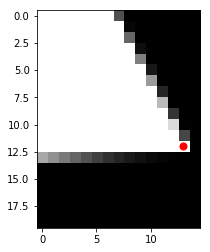

In [4]:
img_gen = CornerImageGenerator(image_width=IMAGE_WIDTH, image_height=IMAGE_HEIGHT).generator()    

# How it works
random_img, random_coord = next(img_gen)
plt.imshow(random_img, cmap='gray')
plt.scatter(random_coord[0], random_coord[1], s=50, c='red', marker='o')
plt.show()

For now we will just focus on predicting the x-coordinate of the corner.

In [5]:
def flatten_and_normalize(image):
    assert isinstance(image, np.ndarray)
    assert 0 <= image.min() and image.max() <= 255
    flat_img = image.reshape(-1)  # flattened image
    flat_norm_img = flat_img / 255
    return flat_norm_img

def coord_to_horisontal_onehot(max_width, coord):
    assert 0 <= coord[0] and coord[0] <= max_width
    x_pos = coord[0]  # horisontal position of corner
    one_hot = np.zeros(max_width, dtype=int)
    one_hot[x_pos] = True
    return one_hot

# How it works (reshaping and rounding to make it look nice in the notebook)
random_img_prep_x = flatten_and_normalize(random_img)
random_img_prep_y = coord_to_horisontal_onehot(IMAGE_WIDTH-1, random_coord)
assert random_img_prep_x.shape == (IMAGE_HEIGHT * IMAGE_WIDTH, )
print('x:\n', random_img_prep_x.reshape(IMAGE_HEIGHT, IMAGE_WIDTH).round(1))
print('y:\n', random_coord[0])
print('y (one-hot):\n', random_img_prep_y)

x:
 [[ 1.   1.   1.   1.   1.   1.   1.   0.3  0.   0.   0.   0.   0.   0.   0. ]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   0.4  0.   0.   0.   0.   0.   0. ]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   0.1  0.   0.   0.   0.   0. ]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   0.5  0.   0.   0.   0.   0. ]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.1  0.   0.   0.   0. ]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.6  0.   0.   0.   0. ]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.1  0.   0.   0. ]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.7  0.   0.   0. ]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.2  0.   0. ]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.9  0.   0. ]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.3  0. ]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.

In [6]:
def generator_x_y():
    while True:
        image, coord = next(img_gen)
        x = flatten_and_normalize(image)
        y = random_coord[0]
        yield x, y
        
def generator_x_y_onehot():
    while True:
        image, coord = next(img_gen)
        x = flatten_and_normalize(image)
        y = coord_to_horisontal_onehot(IMAGE_WIDTH, coord)
        yield x, y

def generate_batch(generator, size):
    images, coords = list(zip(*islice(generator, size)))
    return np.array(images), np.array(coords).reshape(size, -1)

# How it works
next_batch = generate_batch(generator_x_y(), 3)
assert (next_batch[0].shape, next_batch[1].shape) == ((3, 300), (3, 1))
next_batch = generate_batch(generator_x_y_onehot(), 3)
assert (next_batch[0].shape, next_batch[1].shape) == ((3, 300), (3, 15))

### Building the neural network

This model is based on as simple Tensorflow MNIST tutorial. No other parameters has been tried out.

We will experiment with both classification (with onehot encoded coordinates) and regression.

In [7]:
# Use this toggle to switch between classification and regression

# TASK = 'regression'
TASK = 'classification'

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(
        x,
        W,
        strides=[1, 1, 1, 1],
        padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(
        x,
        ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        padding='SAME')

In [9]:
if TASK == 'classification':
    no_output_classes = IMAGE_WIDTH
if TASK == 'regression':
    no_output_classes = 1

x = tf.placeholder(tf.float32, shape=(None, IMAGE_HEIGHT * IMAGE_WIDTH))
y_ = tf.placeholder(tf.float32, shape=(None, no_output_classes))

x_2dim = tf.reshape(x, [-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_2dim, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)  # (20, 15) -> (10, 8)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)  # (10, 8) -> (5, 4)

h_pool2_flat = tf.reshape(h_pool2, [-1, 5 * 4 * 64])

W_fc1 = weight_variable([5 * 4 * 64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

W_fc2 = weight_variable([1024, no_output_classes])
b_fc2 = bias_variable([no_output_classes])

y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

In [10]:
if TASK == 'classification':
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
if TASK == 'regression':
    loss = tf.reduce_mean((y_ - y_conv)**2)

train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

# Only relavant for classification task, but it does no harm to do the computation
onehot_mse = tf.reduce_mean((tf.argmax(y_conv, 1) - tf.argmax(y_, 1)) ** 2)

In [11]:
ITERATIONS = 2000

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(ITERATIONS):
    batch = generate_batch(generator_x_y(), 50)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    if i % 100 == 0:
        if TASK == 'classification':
            train_mse = onehot_mse.eval(feed_dict={x: batch[0], y_: batch[1]})
            print('step %d, training error (onehot) %g' % (i, train_mse))
        if TASK == 'regression':
            print('step %d, training error %g' % (i, loss.eval(feed_dict={x: batch[0], y_: batch[1]})))

ValueError: Cannot feed value of shape (50, 1) for Tensor 'Placeholder_1:0', which has shape '(?, 15)'

### Testing and evaluating the trained model

In [ ]:
test_batch = generate_batch(generator_x_y(), 500)
print("Test error:", sess.run(loss, feed_dict={x: test_batch[0], y_: test_batch[1]}))

In [ ]:
random.seed(1337)

for i in range(10):
    prep_sample = next(generator_x_y())
    pred = y_conv.eval(feed_dict={x: [prep_sample[0]]})

    print("Input data:")
    plt.imshow(prep_sample[0].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
    plt.show()

    print("Predicttion:")
    if TASK == 'classification':
        plt.figure(figsize=(3,1))
        plt.imshow(pred, cmap='Reds')
        plt.show()
    if TASK == 'regression':
        print(pred)

In [ ]:
for test_img_file in glob.glob('./test_photos/*'):
    orig = skimage.io.imread(test_img_file, as_grey=True)
    down_scaled = skimage.transform.resize(orig, output_shape=(IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant')
    
    prep_img = down_scaled.reshape(-1) 
    pred = y_conv.eval(feed_dict={x: [prep_img]})
    
    print("Original:")
    plt.imshow(orig, cmap='gray')
    plt.show()
    
    print("Down scaled:")
    plt.imshow(down_scaled, cmap='gray')
    plt.show()
    
    print("Predicted x-coordinates:")
    plt.figure(figsize=(3,1))
    plt.imshow(pred, cmap='Reds')
    plt.show()

In [ ]:
for test_img_file in glob.glob('./test_photos/*'):
    orig = skimage.io.imread(test_img_file, as_grey=True)
    down_scaled = skimage.transform.resize(orig, output_shape=(IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant')
    high_contrast = skimage.exposure.adjust_sigmoid(down_scaled)
    
    prep_img = high_contrast.reshape(-1) 
    pred = y_conv.eval(feed_dict={x: [prep_img]})
    
    print("Original:")
    plt.imshow(orig, cmap='gray')
    plt.show()
    
    print("Down scaled:")
    plt.imshow(high_contrast, cmap='gray')
    plt.show()
    
    print("Predicted x-coordinates:")
    plt.figure(figsize=(3,1))
    plt.imshow(pred, cmap='Reds')
    plt.show()